64657852
64652771


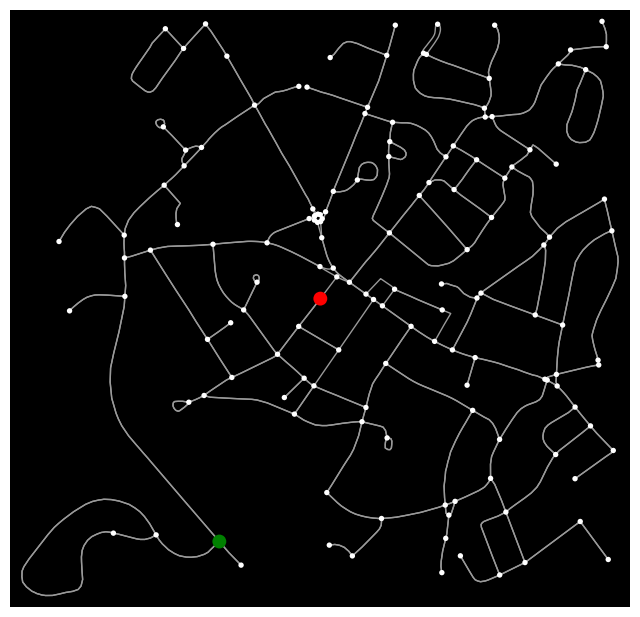

In [27]:
import json
import copy
import math
from dataclasses import dataclass
from typing import TypeAlias

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib

import osmnx as ox
from IPython.display import HTML

ox.settings.use_cache = True
ox.settings.cache_folder = './cache' 

address = "Cary Memorial Library, 1874 Massachusetts Ave, Lexington, MA 02420"

try:
    G = ox.graph_from_address(address, dist=800, network_type="drive")
    start_node = ox.distance.nearest_nodes(G, X=-71.2299, Y=42.4479)
    print(start_node)
    end_node = ox.distance.nearest_nodes(G, X=-71.2328, Y=42.4429)
    print(end_node)
    node_colors = ['red' if node == start_node else 'green' if node == end_node else 'white' for node in G.nodes()]
    node_sizes = [100 if node == start_node or node == end_node  else 15 for node in G.nodes()]

    adj_dict = {
        int(u): {str(v): round(float(d[0]['length']), 2) for v, d in nbrs.items()}
        for u, nbrs in G.adj.items()
    }

    fig, ax = ox.plot_graph(
        G, 
        node_color=node_colors, 
        node_size=node_sizes, 
        node_zorder=3, 
        bgcolor='black'
    )
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")

In [28]:
Vertex: TypeAlias = int
Weight: TypeAlias = int | float

@dataclass
class Edge:
    vertex: Vertex
    weight: Weight

Neighbors: TypeAlias = dict[Vertex, Weight]

# Graph Library

def graph_get_neighbors(vertex: Vertex, adj_dict: dict[Vertex, Neighbors]) -> Neighbors:
    return copy.deepcopy(adj_dict[vertex])

def graph_hasmore_neighbors(nbors: Neighbors) -> bool:
    return len(nbors) > 0

def graph_next_neighbor_pair(nbors: Neighbors) -> Edge:
    key, weight = next(iter(nbors.items()))
    nbors.pop(key)
    return Edge(vertex=key, weight=weight)

def graph_next_neighbor_key(nbors: Neighbors) -> Vertex:
    key, weight = next(iter(nbors.items()))
    nbors.pop(key)
    return key

In [32]:
nbors = graph_get_neighbors(64657852, adj_dict)
while graph_hasmore_neighbors(nbors):
    print(graph_next_neighbor_pair(nbors))


Edge(vertex='472421843', weight=78.06)
Edge(vertex='64656625', weight=100.74)


In [31]:
# DFS implementation
def dfs(start: Vertex, end: Vertex) -> bool:
    visited: set[Vertex] = set()

    def dfs_helper(current: Vertex, target: Vertex, visited: set[Vertex]) -> bool:
        if current == target:
            return True
        
        visited.add(current)
        nbors = graph_get_neighbors(current)
        
        while graph_hasmore_neighbors(nbors):
            neighbor = graph_next_neighbor_key(nbors)

            if neighbor not in visited:
                if dfs_helper(neighbor, target, visited):
                    return True
        return False
    
    return dfs_helper(start, end, visited)

Path found with 54 nodes.


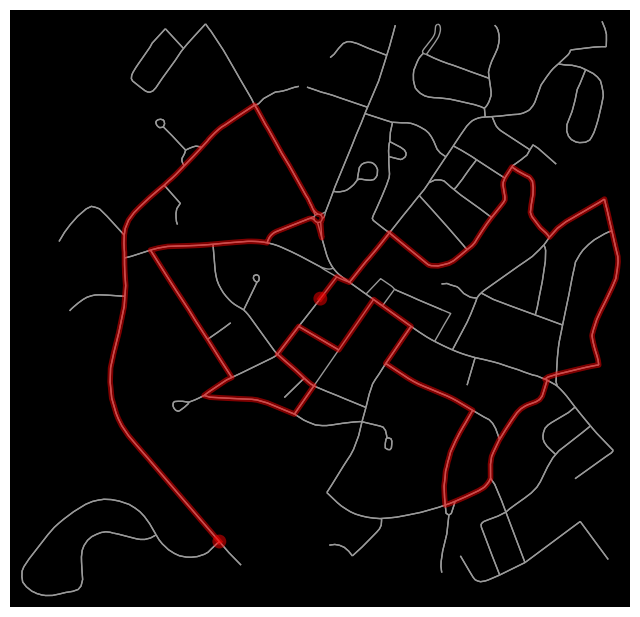

In [ ]:
# DFS impementation - saves path and displays it
def dfs_with_path(start, end):
    visited = set()
    path = []
    
    def dfs_helper(current, target, visited, path):
        visited.add(current)
        path.append(int(current))
        
        if int(current) == int(target):
            return True
        
        nbors = graph_get_neighbors(current)
        while graph_hasmore_neighbors(nbors):
            neighbor = graph_next_neighbor_key(nbors)
            if neighbor not in visited:
                if dfs_helper(neighbor, target, visited, path):
                    return True
                
        path.pop()
        return False

    success = dfs_helper(str(start), str(end), visited, path)
    return path if success else None

def visualize_dfs_route(G, path):
    if not path:
        print("No path found between the specified nodes.")
        return

    print(f"Path found with {len(path)} nodes.")
    
    fig, ax = ox.plot_graph_route(
        G, 
        path, 
        route_color="red", 
        route_linewidth=4, 
        node_size=0, 
        bgcolor='black'
    )
    plt.show()

path_nodes = dfs_with_path(start_node, end_node)
visualize_dfs_route(G, path_nodes)

In [ ]:
# DFS animation

def animate_dfs(G, start_node, end_node):
    visited = set()
    visit_order = []
    matplotlib.rcParams['animation.embed_limit'] = 1000.0
    def dfs_recorder(current, target):
        if current in visited:
            return False
        
        visited.add(current)
        visit_order.append(current)
        
        if int(current) == int(target):
            return True
        
        nbors = graph_get_neighbors(current)
        while graph_hasmore_neighbors(nbors):
            neighbor = graph_next_neighbor_key(nbors)
            if neighbor not in visited:
                if dfs_recorder(neighbor, target):
                    return True
        return False

    dfs_recorder(str(start_node), str(end_node))

    fig, ax = ox.plot_graph(G, node_size=0, edge_color='#333333', bgcolor='black', show=False, close=False)
    
    search_dot, = ax.plot([], [], 'ro', markersize=8, label='Searching...')
    path_line, = ax.plot([], [], color='red', linewidth=2, alpha=0.6)
    target_node = G.nodes[int(end_node)]
    ax.scatter(target_node['x'], target_node['y'], c='green', s=100, label='Goal', zorder=5)

    x_coords = [G.nodes[int(node)]['x'] for node in visit_order]
    y_coords = [G.nodes[int(node)]['y'] for node in visit_order]

    def init():
        search_dot.set_data([], [])
        path_line.set_data([], [])
        return search_dot, path_line

    def update(frame):
        search_dot.set_data([x_coords[frame]], [y_coords[frame]])
        path_line.set_data(x_coords[:frame+1], y_coords[:frame+1])
        return search_dot, path_line
    ani = FuncAnimation(fig, update, frames=len(visit_order), 
                        init_func=init, blit=True, interval=50)
    
    plt.legend()
    return ani

ani = animate_dfs(G, start_node, end_node)
ani.save('dfs_animation.gif', writer='pillow', fps=20)
HTML(ani.to_jshtml())

In [9]:
print(json.dumps(adj_dict, indent=2))

{
  "64639158": {
    "64647234": 137.06221533507926,
    "64649967": 46.158072980776055,
    "64646151": 206.82741447004116
  },
  "64639194": {
    "64654898": 7.093872141933723,
    "64658688": 36.1738631221347,
    "64654007": 209.28357784564673
  },
  "64639502": {
    "64648716": 78.26365550730522,
    "64641296": 140.57084992683195
  },
  "64639528": {
    "64641296": 179.2301716726597,
    "3020090243": 228.2323385726141
  },
  "64639663": {
    "64653734": 102.48650063372202,
    "64647136": 159.82405055646788,
    "64648165": 146.8280435977874,
    "64656625": 100.10994091096116
  },
  "64639854": {
    "64654872": 188.09896004852476
  },
  "64640754": {
    "12319695231": 166.57113836597898,
    "472421843": 56.520215767003606
  },
  "64640862": {
    "64648620": 267.0433226590711,
    "64660214": 47.70165412476638,
    "64648165": 94.95354292546618
  },
  "64640894": {
    "64653909": 195.49011063745922,
    "64659428": 79.29832314382406,
    "64644867": 69.64599577775883
 

In [ ]:
# Priority queue Library

def enq(q: list[Edge], d: Edge):
    q.append(d)

def deq(q: list[Edge]) -> Edge:
    try:
        m = 0
        for i in range(len(q)):
            if q[i].weight > q[m].weight:
                m = i
        item = q[m]
        del q[m]
        return item
    
    except IndexError:
        print("Queue empty.")
        exit()

def is_empty(q: list[Edge]) -> bool:
    return len(q) == 0

In [ ]:
# init a dict that represents nodes and their weights aka the dist array - init all weights too INT_MAX
# set up BFS algorithm using a priority queue - edge weights are used for priority
# each time visiting a node, make it as visited, then calculate its weight based on the path to get there (do i need to do this if i already have a dist array?)

dist = {}
for node in G.nodes():
    dist[int(node)] = math.inf

dist[start_node] = 0
to_visit = []

while is_empty(to_visit) == False:
    dist1 = deq(to_visit)
    